In [1]:
# Extracao de dados de patentes
# url - www.freepatentsonline.com
#
# Henrique Cursino Vieira
# versao 0.1 

In [2]:
# dataframe
import re
import pandas as pd

# webscraping
import requests
from bs4 import BeautifulSoup

# nuvem de palavras
from wordcloud import WordCloud

In [3]:
# cada pagina lista 50 patentes, alterar a variavel n para obter o numero de
# patentes de interesse
p = 6

In [4]:
# Nome das colunas
columns = ["Match", "Document", "Document_Title", "Score"]

In [5]:
rows = []
for pagina in range(1,p+1):
    pagina = str(pagina)
    link = "https://www.freepatentsonline.com/result.html?p={}&sort=relevance&srch=top&query_txt=agronomy&patents_us=on".format(pagina)
    
    page = requests.get(link)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    # Capturando o conteudo da tag <td> e pulando as duas primeiras tags
    listing_table = soup.findAll("td")[2:202]    
    
    for i in range(0, len(listing_table), 4):

    #     print(i)
        match, document, document_title, score = listing_table[i:i+4]
        rows.append([match, document, document_title, score])  

In [6]:
print('Total de linhas:', len(rows))

Total de linhas: 300


In [7]:
# Verificando o conteudo
listing_table[6]

<td valign="top" width="60%">
<a href="/6338348.html">Method of treating tobacco to reduce nitrosamine content, and products produced thereby</a>
         
                            <br/>
                Methods of reducing the content of and preventing formation of carcinogenic nitrosamines in harvested leafy plants such as tobacco and marijuana, are disclosed. The methods are directed to...    </td>

In [8]:
rows[5][2].findAll('a')

[<a href="/y2003/0125877.html">Methods and systems for managing farmland</a>]

In [9]:
# lista de links
urls = []
for i in range(len(rows)):

    td = rows[i][2]
    a = td.findAll('a')
    
    if a:
        urls.append("https://www.freepatentsonline.com"+a[0].get('href'))

In [10]:
len(urls)

300

In [12]:
# extraindo os dados dos documentos de patentes
tmp = dict()

for i, url in enumerate(urls):
    
    print('process', i)
    
    tmp[i] = []
    url_splited = url.split('/')
    
    if len(url_splited) == 4:
        idx = url_splited[3].replace('.html', '')
        
    if len(url_splited) == 5:
        idx = url_splited[4].replace('.html', '')

    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    
    tmp[i].append(['idx', idx])
    
    for row in soup.findAll("div", {"class":"disp_doc2"}):
        
        title_content = row.findAll("div", {"class":"disp_elm_title"})
        text_content = row.findAll("div", {"class":"disp_elm_text"})
        title = None
        text = None
        
        if title_content:
            title = title_content[0].text

            if text_content:
                text = text_content[0].text

            tmp[i].append([title, text])

process 0
process 1
process 2
process 3
process 4
process 5
process 6
process 7
process 8
process 9
process 10
process 11
process 12
process 13
process 14
process 15
process 16
process 17
process 18
process 19
process 20
process 21
process 22
process 23
process 24
process 25
process 26
process 27
process 28
process 29
process 30
process 31
process 32
process 33
process 34
process 35
process 36
process 37
process 38
process 39
process 40
process 41
process 42
process 43
process 44
process 45
process 46
process 47
process 48
process 49
process 50
process 51
process 52
process 53
process 54
process 55
process 56
process 57
process 58
process 59
process 60
process 61
process 62
process 63
process 64
process 65
process 66
process 67
process 68
process 69
process 70
process 71
process 72
process 73
process 74
process 75
process 76
process 77
process 78
process 79
process 80
process 81
process 82
process 83
process 84
process 85
process 86
process 87
process 88
process 89
process 90
process 9

In [14]:
# Verificando o conteudo de text
tmp[0]

[['idx', '0387659'],
 ['Title:',
  '\n\n                    SYSTEMS AND METHODS FOR ADJUSTING THE OUTPUT OF A FIELD MEASUREMENT SYSTEM TO CONFORM TO AGRONOMY MEASUREMENTS                \n'],
 ['Abstract:',
  '\n            The present disclosure provides systems and methods for adjusting the output of a field measurement system to conform to agronomy measurements. In particular, the present subject matter is directed to a calibration process and system that uses a calibration model to convert field measurement data expressed according to an automatic system metric into agronomy data that is expressed according to an agronomy metric.         '],
 ['', '\n\n\n\n\n'],
 ['Inventors:',
  '\n                            Ferrari, Luca (Modena, IT)                \n                            Posselius, John H. (Ephrata, PA, US)                \n                            Henry, James W. (Saskatoon, CA)                \n                            Bybee, Taylor C. (Logan, UT, US)             

In [15]:
rows = []
for i in range(len(tmp)):
    
    row = [tmp[i][0][1], tmp[i][1][1], tmp[i][2][1]]
    rows.append(row)

In [16]:
data = pd.DataFrame(rows, columns = ['idx', 'title_raw', 'text_raw'])
data.shape

(300, 3)

In [17]:
data.head(10)

,idx,title_raw,text_raw
0,0387659,\n\n SYSTEMS AND METHODS FO...,\n The present disclosure provides ...
1,10729058,\n\n Systems and methods fo...,\n The present disclosure provides ...
2,6745128,\n\n Methods and systems fo...,\n Methods and systems for characte...
3,6549852,\n\n Methods and systems fo...,\n Methods and systems for characte...
4,0018431,\n\n METHODS AND SYSTEMS FO...,\n Methods and systems for characte...
5,0125877,\n\n Methods and systems fo...,\n Methods and systems for characte...
6,0155623,\n\n Agronomy bonus system ...,\n A method and system for encourag...
7,10796261,\n\n Agricultural enterpris...,\n A computer-implemented cloud-bas...
8,0394579,\n\n AGRICU...,\n United State...
9,0322426,\n\n AGRICULTURAL ENTERPRIS...,\n A computer-implemented cloud-bas...


In [18]:
def preprocess_text(text = None):
    
    processed_text = re.sub('\n{1,}', '', text).strip().lower()    
    return processed_text

In [19]:
# pre processamento dos dados e gerando uma coluna unificando titulo e texto
data['title']   = data['title_raw'].apply(lambda x : preprocess_text(x))
data['text']    = data['text_raw'].apply(lambda x : preprocess_text(x))
data['content'] = data['title'] + " " + data['text']
data.head(10)

,idx,title_raw,text_raw,title,text,content
0,0387659,\n\n SYSTEMS AND METHODS FO...,\n The present disclosure provides ...,systems and methods for adjusting the output o...,the present disclosure provides systems and me...,systems and methods for adjusting the output o...
1,10729058,\n\n Systems and methods fo...,\n The present disclosure provides ...,systems and methods for adjusting the output o...,the present disclosure provides systems and me...,systems and methods for adjusting the output o...
2,6745128,\n\n Methods and systems fo...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
3,6549852,\n\n Methods and systems fo...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
4,0018431,\n\n METHODS AND SYSTEMS FO...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
5,0125877,\n\n Methods and systems fo...,\n Methods and systems for characte...,methods and systems for managing farmland,methods and systems for characterizing and man...,methods and systems for managing farmland meth...
6,0155623,\n\n Agronomy bonus system ...,\n A method and system for encourag...,agronomy bonus system and method,a method and system for encouraging farmers to...,agronomy bonus system and method a method and ...
7,10796261,\n\n Agricultural enterpris...,\n A computer-implemented cloud-bas...,agricultural enterprise management method and ...,a computer-implemented cloud-based agricultura...,agricultural enterprise management method and ...
8,0394579,\n\n AGRICU...,\n United State...,agricultural enterprise management method and ...,united states patent application 20200394579 ...,agricultural enterprise management method and ...
9,0322426,\n\n AGRICULTURAL ENTERPRIS...,\n A computer-implemented cloud-bas...,agricultural enterprise management method and ...,a computer-implemented cloud-based agricultura...,agricultural enterprise management method and ...


In [20]:
data['content'].tolist()[10]

'augmented-human field inspection tools for automated phenotyping systems and agronomy tools systems and methods for augmented-human field inspection tools for automated phenotyping systems and agronomy tools. in one embodiment, a method for plant phenotyping, includes: acquiring a first set of observations about plants in a field by a trainer. the trainer carries a sensor configured to collect observations about the plant, and the first set of observations includes ground truth data. the method also includes processing the first set of observations about the plants by a trait extraction model to generate instructions for a trainee; and acquiring a second set of observations about the plants by a trainee while the trainee follows the instructions.'

In [25]:
# nuvem de palavras
text = ', '.join(list(data['content'].values))
wordcloud = WordCloud(background_color="white", 
                      max_words=5000, 
                      contour_width=3, 
                      contour_color='steelblue',
                      width=1200, 
                      height=800,
                      collocations=False)

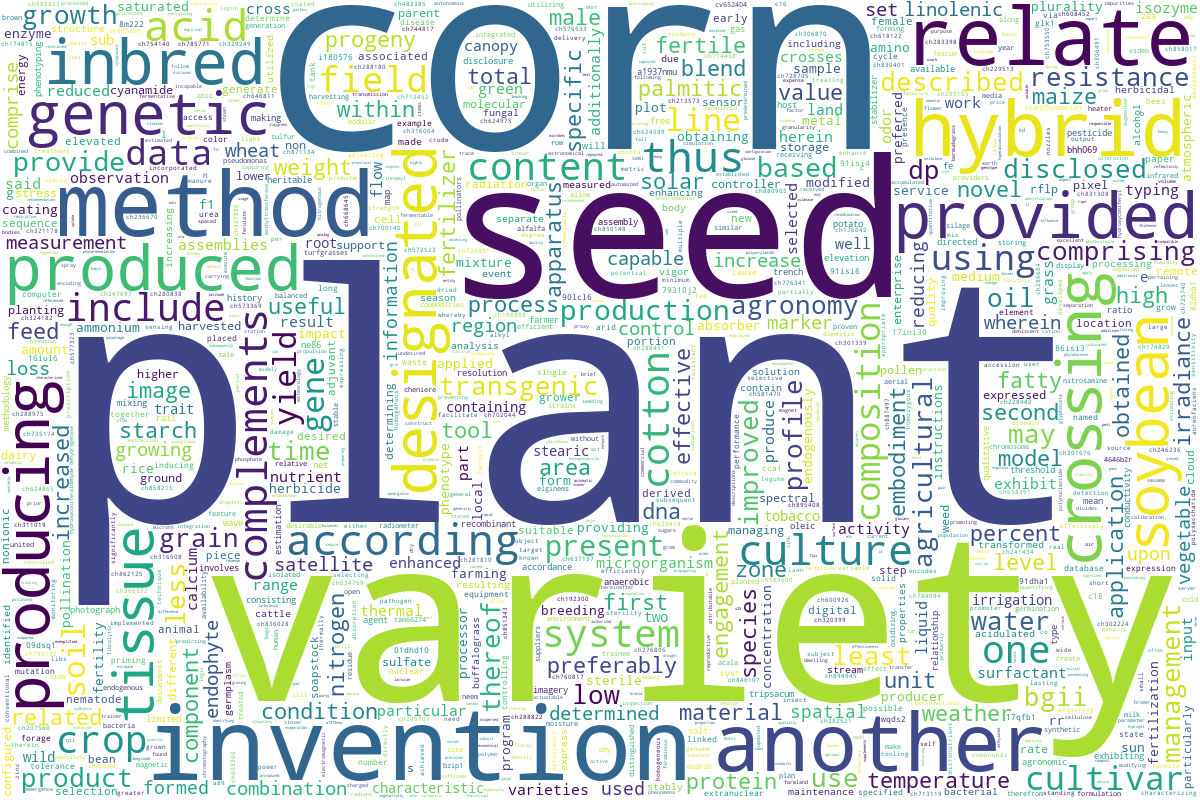

In [26]:
wordcloud.generate(text)
wordcloud.to_image()

In [27]:
wordcloud.to_file(filename='wordcloud_preprocess.png')

In [23]:
data.shape

(300, 6)

In [24]:
data.to_csv('patents_data.csv', index = False)